# Sentiment Analysis using RoBERTa model
Author: Mengliu Zhao \
Date: Aug 4, 2024

In this notebook, I'll demo how to perform sentiment analysis using RoBERTa (robust version of BERT) model on a Kaggle tweet dataset.\
RoBERTa paper: https://arxiv.org/abs/1907.11692\
transformers doc: https://huggingface.co/docs/transformers/en/model_doc/roberta

Kaggle dataset:
* source: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification
* labels: There are five sentiment labels in the dataset:{"Neutral", "Positive", "Extremely Negative", "Negative", "Extremely Positive"}
* data: 41157 tweets in the train set and 3798 tweets in the testing set

Architecture: The problem is converted into an ML task of 5-label text classification. Due to the very limited training set, we freeze the pre-trained RoBERTa backbone and add a linear layer for the classification.

python==3.11



## 1. Dataset EDA
We'll explore the dataset from the following perspectives:
* training and test size
* balance of the labels
* statistics of the tweet lengths in characters
* statistics of the sequence lengths in tokens (using pre-trained tokenizer) - we'll use max_len=128 for truncation in the finetune stage 

In [2]:
import pandas as pd

train_df = pd.read_csv("./data/Corona_NLP_train.csv", encoding='latin-1')
test_df = pd.read_csv("./data/Corona_NLP_test.csv", encoding='latin-1')

print(train_df[:10])
print(train_df.shape, test_df.shape)

   UserName  ScreenName                   Location     TweetAt  \
0      3799       48751                     London  16-03-2020   
1      3800       48752                         UK  16-03-2020   
2      3801       48753                  Vagabonds  16-03-2020   
3      3802       48754                        NaN  16-03-2020   
4      3803       48755                        NaN  16-03-2020   
5      3804       48756  ÃT: 36.319708,-82.363649  16-03-2020   
6      3805       48757       35.926541,-78.753267  16-03-2020   
7      3806       48758                    Austria  16-03-2020   
8      3807       48759            Atlanta, GA USA  16-03-2020   
9      3808       48760           BHAVNAGAR,GUJRAT  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give eld

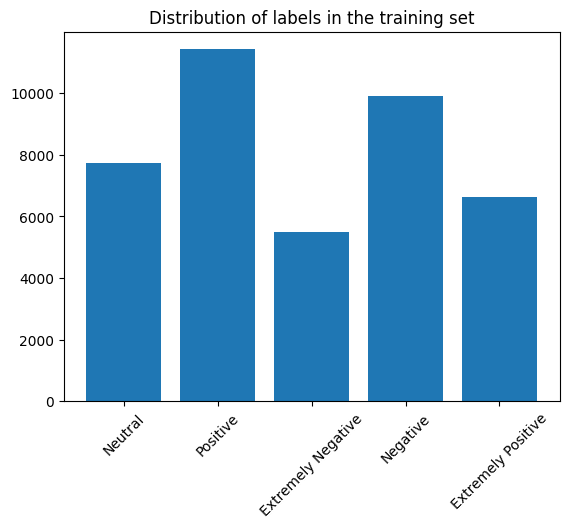

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

c = list(Counter(train_df["Sentiment"]).items())

sentiment_list = [item [0] for item in c]
num_labels = len(sentiment_list)

plt.figure()
plt.title("Distribution of labels in the training set")
plt.bar(range(len(c)), [item [1] for item in c])
plt.xticks(range(len(c)), sentiment_list, fontsize=10, rotation=45)
plt.show()

In [5]:
# converting text labels to numbers
sentiment_dict = {name: value for value, name in zip(range(len(sentiment_list)), sentiment_list)}
print(sentiment_dict)

{'Neutral': 0, 'Positive': 1, 'Extremely Negative': 2, 'Negative': 3, 'Extremely Positive': 4}


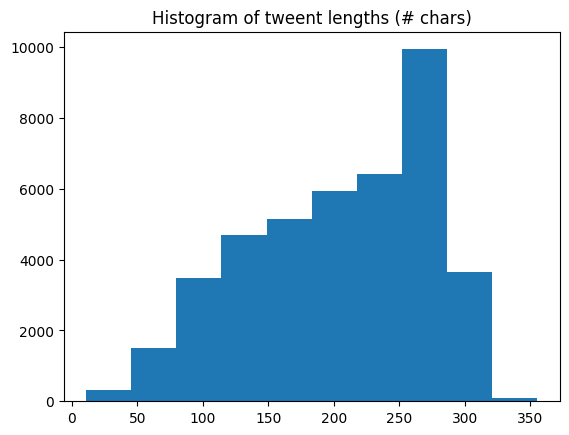

In [7]:
from matplotlib.pyplot import hist

tweet_len = [len(tweet) for tweet in train_df["OriginalTweet"].tolist()]
plt.figure()
plt.title("Histogram of tweent lengths (# chars)")
_ = hist(tweet_len, 10)


c:\Users\mengl\anaconda3\envs\gradio\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


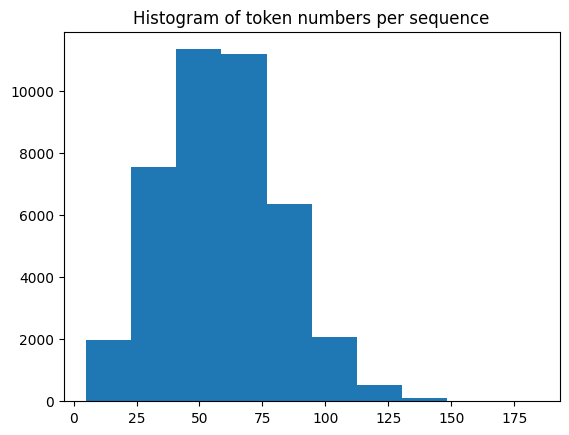

In [8]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("FacebookAI/roberta-base")

token_seq_len = [len(tokenizer.encode(tweet)) for tweet in train_df["OriginalTweet"].tolist()]

plt.figure()
plt.title("Histogram of token numbers per sequence")
_ = hist(token_seq_len, 10)


## 2. A Deeper Dive into the Tokenizer Output
We'll explain a bit about the tokenized output. \

The RoBERTa tokenizer:
* the tokenizer is trained in a BPE fashion: https://huggingface.co/docs/transformers/en/model_doc/roberta#transformers.RobertaTokenizer
* BPE stands for Byte-Pair Encoding, which merges frequent words into a few token and merges less frequent words into a more diversified token combinations: https://huggingface.co/learn/nlp-course/en/chapter6/5
* the vocab attribute contains the whole dictionary of the merged tokens in the format of (token, token_id)
* it contains special tokens: `["<s>", "</s>", "<unk>", "<pad>", "<mask>"]`
* the `cls_token` (classification token) is `<s>` and the id is `0`
* the `pad_token` (padding token) is `<pad>` and the id is `1`

The tokenizer output contains the following items:
* input_ids: This is the sequence of token ids. Note that the sequence always starts from id `0`, which is the `cls_token`, and ended with id (if padded) `1`, which is the `pad_token`
* attention_mask: This is a binary number sequence of the same length of the input_ids, where `1` indicates the token should be used, and `0` indicates the token is padded and shouldn't be used
* token_type_ids: This is equivalent to segment IDs. Since BERT/RoBERTa is pre-trained in "Next sentence Prediction" style, the segment IDs is useful in such scenarios. But we don't need it for single-sentence text classification.

Two different encoding functions for the tokenizer:
* encode: it only returns the input_ids
* encode_plus: it returns the `<input_ids, attention_mask, token_type_ids>`. For a clear representation for demo purposes, we choose the encode_plus as the encoding function for the tokenizer.

In [23]:
list(tokenizer.vocab.items())[:10]

[('pocket', 27763),
 ('Ġdiscriminate', 28224),
 ('ĠOrt', 29968),
 ('ĠMUST', 39282),
 ('uron', 39508),
 ('Char', 42379),
 ('modified', 44887),
 ('Ġconspicuous', 39084),
 ('ĠGlenn', 8583),
 ('female', 31372)]

In [29]:
print(tokenizer.all_special_tokens)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)

['<s>', '</s>', '<unk>', '<pad>', '<mask>']
<s> 0
<pad> 1


In [30]:
sentence = train_df["OriginalTweet"][0]
print(sentence)

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8


In [11]:
output = tokenizer.encode_plus(sentence,
                                add_special_tokens=True,
                                max_length=128,
                                return_token_type_ids=True,
                                truncation=True,
                                padding="max_length",
                                )


In [19]:
import numpy as np
# convert to numpy array for display purposes
np.array(output["input_ids"])

array([    0,  1039,  5096,   487,  4503, 12750,   787, 25531,  1215,
         534, 10048,   787, 16084,   405,   705,  1205,   640,    90,
           4,   876,    73,   118,   597,   329,   466,   597,  4688,
         176, 28058,     8,  1205,   640,    90,     4,   876,    73,
        1178,  1000,   401,  4147, 27150,   329,  3376,     8,  1205,
         640,    90,     4,   876,    73,   100,   176,   487,   462,
         329, 46106,  3084,   398,     2,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1]

In [31]:
np.array(output["attention_mask"])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
print(np.array(output["token_type_ids"]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 3. Dataset Class and Classifier Class

In [35]:
import torch
from torch.utils.data import Dataset

class SentimentTextDataset(Dataset):
    def __init__(self,
                 input_text,
                 labels,
                 tokenizer,
                 max_len,
                 ):
        super(SentimentTextDataset, self).__init__()
        self.inputs = []
        for sentence in input_text:
            self.inputs.append(tokenizer.encode_plus(sentence,
                                                     add_special_tokens=True,
                                                     max_length=max_len,
                                                     return_token_type_ids=True,
                                                     truncation=True,
                                                     padding="max_length",
                                                     ))
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return {"input_ids": torch.tensor(self.inputs[index]["input_ids"], dtype=torch.long),
                "attention_mask": torch.tensor(self.inputs[index]["attention_mask"], dtype=torch.long),
                "token_type_ids": torch.tensor(self.inputs[index]["token_type_ids"], dtype=torch.long),
                "labels": torch.tensor(self.labels[index], dtype=torch.long)}

In [36]:
import torch.nn as nn

from transformers import RobertaModel

class SentimentTextClassification(nn.Module):
    def __init__(self,
                 num_labels,
                 ):
        super(SentimentTextClassification, self).__init__()

        self.roberta = RobertaModel.from_pretrained("FacebookAI/roberta-base")
        self.classification_head = nn.Linear(768, num_labels)

    def forward(self,
                input_ids,
                attention_mask,
                token_type_ids,
                ):
        output = self.roberta(input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              ).pooler_output # (batch, 768)

        logits = self.classification_head(output)

        return logits


## 4. Training and Evaluation

Training:
* we choose cross entropy loss as the training loss and AdamW as the optimizer
* torch.amp library is used to fit 128 batch_size on a single V100 gpu. \
See amp library info: https://pytorch.org/docs/stable/amp.html
* the RoBERTa backbone is frozen and only the last linear layer is probed for finetuning purposed

Evaluation:
* we run the scikit-learn classification report for evaluation purposes

In [ ]:
import os
import tqdm

import torch
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch import autocast
from torch.amp import GradScaler

from transformers import RobertaTokenizerFast


save_model_folder = "model_weights"
os.makedirs(save_model_folder, exist_ok=True)

wandb_config = {
    "learning_rate": 1e-5,
    "architecture": "Roberta for sentiment classification",
    "dataset": "Kaggle NLP",
    "epochs": 10,
    "batch_size": 128,
    }

tokenizer = RobertaTokenizerFast.from_pretrained("FacebookAI/roberta-base")

model = SentimentTextClassification(num_labels=num_labels)

## calculate model size in Mbs 
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))

for p in model.parameters():
    p.requires_grad = False

params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(params, lr=wandb_config["learning_rate"])

labels = [sentiment_dict[name] for name in train_df["Sentiment"]]
train_dataset = SentimentTextDataset(train_df["OriginalTweet"].tolist(),
                                labels,
                                tokenizer,
                                max_len=128,
                                )
train_dataloader = DataLoader(train_dataset,
                              batch_size=wandb_config["batch_size"],
                              shuffle=True,
                              drop_last=True,
                              num_workers=4,
                              pin_memory=False,
                              )

test_labels = [sentiment_dict[name] for name in test_df["Sentiment"]]
test_dataset = SentimentTextDataset(test_df["OriginalTweet"].tolist(),
                                test_labels,
                                tokenizer,
                                max_len=128,
                                )
test_dataloader = DataLoader(test_dataset,
                              batch_size=1,
                              shuffle=False,
                              drop_last=False,
                              num_workers=0,
                              pin_memory=False,
                              )

device = "cuda" if torch.cuda.is_available() else "cpu"

model.load_state_dict(torch.load("sentiment_analysis.pt"))
model = model.to(device)

loss_fun = CrossEntropyLoss()
scaler = GradScaler()

for epoch in range(0, wandb_config["epochs"]):
    model.train()
    print("epoch:", epoch)
    for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels= batch["labels"].to(device)

        with autocast(device_type='cuda', dtype=torch.float16):
            logits = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        )

            loss = loss_fun(logits, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        
        # Unscales the gradients for clipping purposes
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        scaler.step(optimizer)
        scaler.update()
 

In [38]:
from sklearn.metrics import classification_report
import tqdm

import torch
from torch.utils.data import DataLoader
from torch import autocast


labels = [sentiment_dict[name] for name in test_df["Sentiment"]]
test_dataset = SentimentTextDataset(test_df["OriginalTweet"].tolist(),
                                labels,
                                tokenizer,
                                max_len=128,
                                )
test_dataloader = DataLoader(test_dataset,
                              batch_size=1,
                              shuffle=False,
                              drop_last=False,
                              num_workers=0,
                              pin_memory=False,
                              )

device = "cuda" if torch.cuda.is_available() else "cpu"
save_model_folder = "model_weights"

tokenizer = RobertaTokenizerFast.from_pretrained("FacebookAI/roberta-base")

model = SentimentTextClassification(num_labels=num_labels)
model.load_state_dict(torch.load(f"{save_model_folder}/sentiment_analysis.pt"))
model.to(device)
model.eval()

prediction = []
target = []

for batch in tqdm.tqdm(test_dataloader, total=len(test_dataloader)):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
      labels= batch["labels"].to(device)

      with autocast(device_type='cuda', dtype=torch.float16):
          logits = model(input_ids=input_ids,
                      attention_mask=attention_mask,
                      token_type_ids=token_type_ids,
                      )
          pred = torch.argmax(logits, dim=1)
          prediction.extend(pred.detach().cpu().numpy())
          target.extend(labels.detach().cpu().numpy())

print(classification_report(target, prediction))

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mengl\AppData\Local\Temp\ipykernel_48024\1963752882.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torc

              precision    recall  f1-score   support

           0       0.91      0.80      0.85       619
           1       0.80      0.80      0.80       947
           2       0.77      0.92      0.84       592
           3       0.82      0.76      0.79      1041
           4       0.84      0.88      0.86       599

    accuracy                           0.82      3798
   macro avg       0.83      0.83      0.83      3798
weighted avg       0.83      0.82      0.82      3798

